In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
dataset = MNIST(root='data/', download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
test_dataset = MNIST(root='data/', train=False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),)
len(dataset),len(test_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(60000, 10000)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(1, 10), device)
print(model)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.13459999859333038, 'val_loss': 2.3035600185394287}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 0.1628, val_loss: 0.2663, val_acc: 0.9439
Epoch [1], last_lr: 0.00760, train_loss: 0.1184, val_loss: 0.1001, val_acc: 0.9729
Epoch [2], last_lr: 0.01000, train_loss: 0.0908, val_loss: 0.1483, val_acc: 0.9621
Epoch [3], last_lr: 0.00950, train_loss: 0.0639, val_loss: 0.0890, val_acc: 0.9730
Epoch [4], last_lr: 0.00812, train_loss: 0.0572, val_loss: 0.0525, val_acc: 0.9828
Epoch [5], last_lr: 0.00611, train_loss: 0.0528, val_loss: 0.0421, val_acc: 0.9876
Epoch [6], last_lr: 0.00389, train_loss: 0.0423, val_loss: 0.0521, val_acc: 0.9836
Epoch [7], last_lr: 0.00188, train_loss: 0.0320, val_loss: 0.0316, val_acc: 0.9908
Epoch [8], last_lr: 0.00050, train_loss: 0.0167, val_loss: 0.0162, val_acc: 0.9947
Epoch [9], last_lr: 0.00000, train_loss: 0.0063, val_loss: 0.0140, val_acc: 0.9955


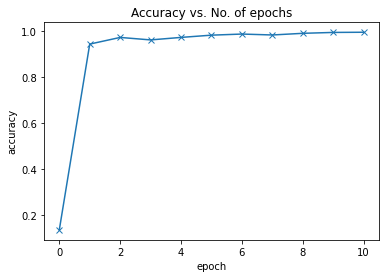

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
plot_accuracies(history)

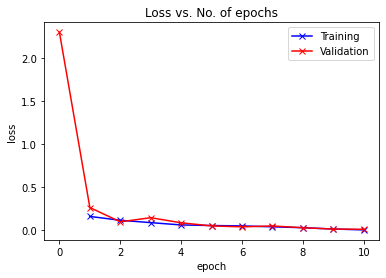

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
plot_losses(history)

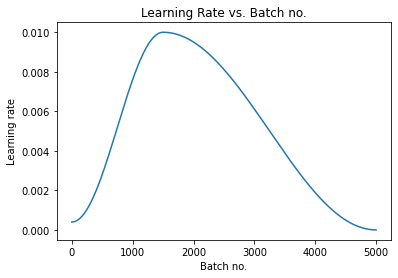

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
plot_lrs(history)

In [ ]:
# test_dataset = MNIST(root='data/', train=False, transform=torchvision.transforms.Compose(
#         [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
#     ),)
# test_dataset = test_dataset.to(device)
img, label = test_dataset[0]

print(img.unsqueeze(0).shape)
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()
predict_image(img, model)

torch.Size([1, 1, 32, 32])


7

In [ ]:
for i in range(20):
    img, label = test_dataset[i]
    pred = predict_image(img, model)
    if pred == label:
        print("Label: ", label, "Predict: ", pred, "Yes")
    else:
        print("Label: ", label, "Predict: ", pred, "No")

Label:  7 Predict:  7 Yes
Label:  2 Predict:  2 Yes
Label:  1 Predict:  1 Yes
Label:  0 Predict:  0 Yes
Label:  4 Predict:  4 Yes
Label:  1 Predict:  1 Yes
Label:  4 Predict:  4 Yes
Label:  9 Predict:  9 Yes
Label:  5 Predict:  5 Yes
Label:  9 Predict:  9 Yes
Label:  0 Predict:  0 Yes
Label:  6 Predict:  6 Yes
Label:  9 Predict:  9 Yes
Label:  0 Predict:  0 Yes
Label:  1 Predict:  1 Yes
Label:  5 Predict:  5 Yes
Label:  9 Predict:  9 Yes
Label:  7 Predict:  7 Yes
Label:  3 Predict:  3 Yes
Label:  4 Predict:  4 Yes


In [ ]:
torch.save(model.state_dict(), 'mnist-resnet9.pth')